# Object detection

In this project we will build object detection model for dataset with fruits pictures. 

In [ ]:
!pip install colorama

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, preprocessing, layers, applications, Model, optimizers
from tensorflow.keras.optimizers.experimental import AdamW
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, concatenate
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2
import random
import os
from PIL import Image

%matplotlib inline

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [ ]:
!unzip -q /content/archive.zip

## Data preprocessing

In [ ]:
img_size = 224

In [ ]:
train_path = '../content/train_zip/train' #/content/train_zip
test_path = '../content/test_zip/test'#/content/test_zip

train_images = []
train_labels = []
shape = (img_size,img_size)

for filename in os.listdir(train_path):
    if filename.split('.')[1] == 'jpg':
        img = cv2.imread(os.path.join(train_path,filename))
        train_labels.append(filename.split('_')[0])
        img = cv2.resize(img,shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)

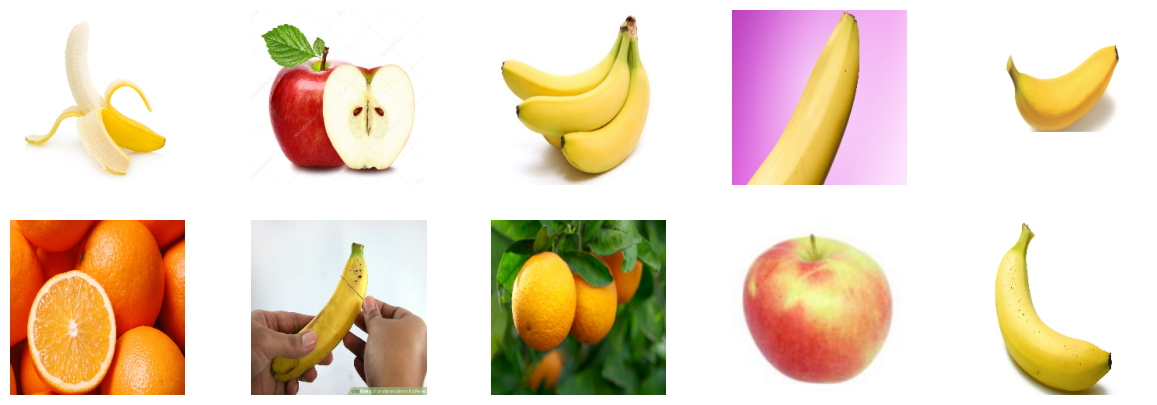

In [ ]:
imgs = [f for f in os.listdir(train_path) if f.endswith('.jpg')]
random_images = random.sample(imgs, 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    if i < len(random_images):
        f = random_images[i]
        img = cv2.imread(os.path.join(train_path,f))
        img = cv2.resize(img,shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
    ax.axis('off')

In [ ]:
train_labels = pd.get_dummies(train_labels).values # one-hot encoding
x_train = np.array(train_images)
y_train = train_labels
x_train,x_val,y_train,y_val = train_test_split(x_train,train_labels,random_state=13122023)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    )
datagen.fit(x_train)
train_data = datagen.flow(x_train, y_train,batch_size=18)

In [ ]:
test_images = []
test_labels = []
test_path = '../content/test_zip/test'

for filename in os.listdir(test_path):
    if filename.split('.')[1] == 'jpg':
        img = cv2.imread(os.path.join(test_path,filename))
        test_labels.append(filename.split('_')[0])
        img = cv2.resize(img,shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_images.append(img)

x_test = np.array(test_images)
label_dict = {'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}
new_labels = [label_dict[fruit] for fruit in test_labels]

In [ ]:
class SpinalNet(tf.keras.Model):
    def __init__(self, half_input, num_filters, num_classes):
        super(SpinalNet, self).__init__()

        self.half_input = half_input
        self.num_filters = num_filters
        self.num_classes = num_classes

        self.SpinalLayer1 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input,)),
            BatchNormalization(),
            ReLU(),
            # First layer use num_filters as input
        ])
        # Second till Output-1 layers use half_input+num_filters as input
        self.SpinalLayer2 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.SpinalLayer3 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.SpinalLayer4 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.Output = Sequential([
            Dropout(0.5),
            Dense(units=self.num_classes, input_shape=(self.num_filters*4,), activation ='softmax'),
            # num_filters times 4 ("4" here is number of SpinalNet I used)
        ])

    def call(self, x):
        x1 = self.SpinalLayer1(x[:, 0:self.half_input])
        x2 = self.SpinalLayer2(concatenate([x[:,self.half_input:2*self.half_input], x1], axis=1))
        x3 = self.SpinalLayer3(concatenate([ x[:,0:self.half_input], x2], axis=1))
        x4 = self.SpinalLayer4(concatenate([ x[:,self.half_input:2*self.half_input], x3], axis=1))

        x = concatenate([x1, x2])
        x = concatenate([x, x3])
        x = concatenate([x, x4])
        x = self.Output(x)

        return x

In [ ]:
def ResNet50_Spinal(num_filters, num_classes):
    resnet = applications.ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    last_output = resnet.layers[-2].output
    num_features = resnet.layers[-1].input_shape[-1]
    half_input = round(num_features//2)
    num_filters = num_filters
    num_classes = num_classes
    spinalnet = SpinalNet(half_input = half_input, num_filters = 512, num_classes=num_classes)
    spinalnet.build(input_shape= (None, resnet.layers[-1].input_shape[-1]))
    input = Input(shape=last_output.shape[1:])
    x = spinalnet(last_output)
    resnet_model = keras.models.Model(inputs=resnet.input, outputs=x, name='ResNet101_SpinalNet')
    for layer in resnet.layers:
        layer.trainable = False
    return resnet_model

In [ ]:
resnet_model = ResNet50_Spinal(num_filters = 20, num_classes = 4)

102967424/102967424 [==============================] - 3s 0us/step


## Model fitting

In [ ]:
AdamW = AdamW(1e-4)
resnet_model.compile(optimizer= AdamW, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = ModelCheckpoint('flowers.hdf5',verbose=1, save_best_only= True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

In [ ]:
history = resnet_model.fit(train_data,
                           validation_data = (x_val,y_val),
                           epochs=20,
                           batch_size=32,
                           callbacks= get_callbacks())

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.6705 - accuracy: 0.3111
Epoch 1: val_loss improved from inf to 1.11345, saving model to flowers.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 18s 652ms/step - loss: 1.6705 - accuracy: 0.3111 - val_loss: 1.1134 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.1999 - accuracy: 0.5389
Epoch 2: val_loss improved from 1.11345 to 0.70457, saving model to flowers.hdf5
10/10 [==============================] - 3s 309ms/step - loss: 1.1999 - accuracy: 0.5389 - val_loss: 0.7046 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 1.0753 - accuracy: 0.6500
Epoch 3: val_loss improved from 0.70457 to 0.50296, saving model to flowers.hdf5
10/10 [==============================] - 3s 313ms/step - loss: 1.0753 - accuracy: 0.6500 - val_loss: 0.5030 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.9020 - accuracy: 0.6444
Epoch 4: val_loss improved from 0.50296 to 0.39075, saving model to flowers.hdf5
10/10 [=======================

## Metric

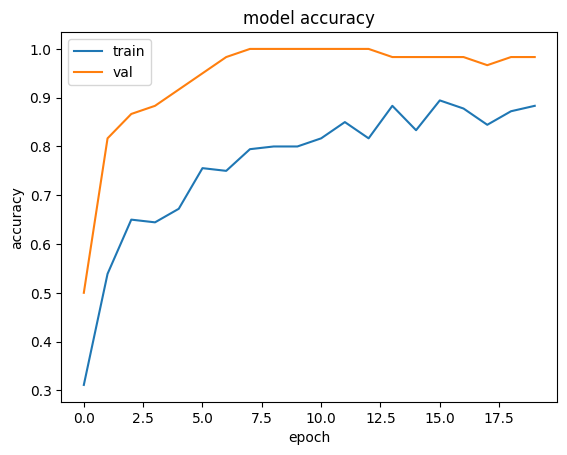

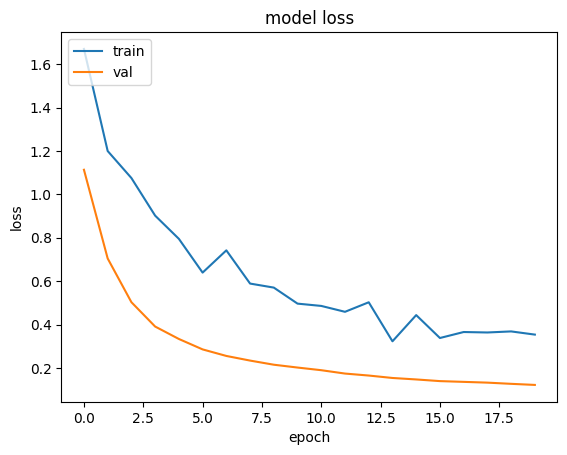

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import cv2
output = { 0:'Apple',1:'Banana',2:'Mixed',3:'Orange'}
def predict (file):
  img_path = file
  img = cv2.imread(img_path)
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  final_img = cv2.resize(rgb_img, (img_size,img_size))
  predictions = resnet_model.predict(np.array([final_img]))
  confidence = np.max(predictions)
  return output[np.argmax(predictions)], confidence*100, rgb_img

In [ ]:
predict_test = resnet_model.predict(x_test)
from sklearn.metrics import accuracy_score
pred_labels = np.argmax(predict_test, axis=1)
accuracy = accuracy_score(new_labels, pred_labels)
print(f"Accuracy test: {accuracy*100:.2f}%")

2/2 [==============================] - 2s 35ms/step
Accuracy test: 95.00%


1/1 [==============================] - 0s 22ms/step


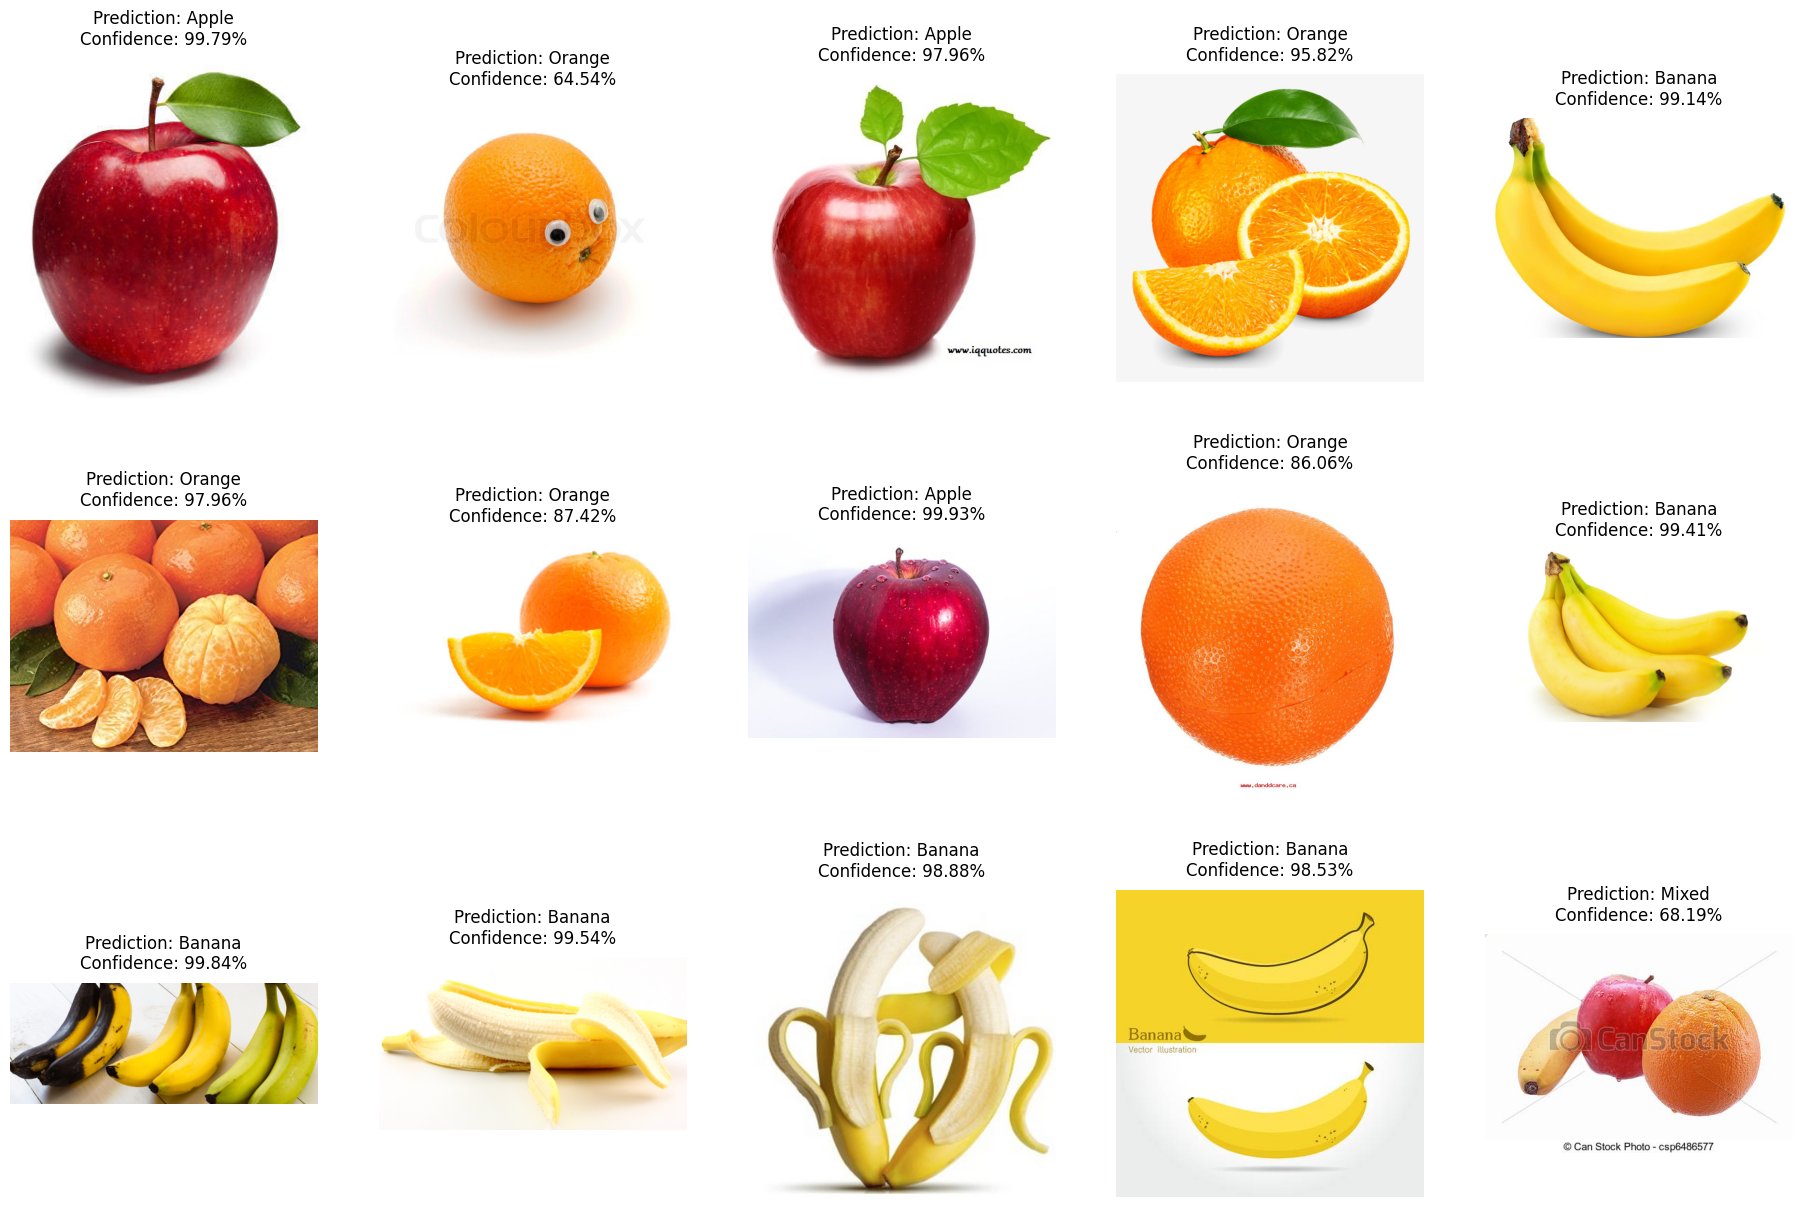

In [ ]:
import os
import random
folder_path = '../content/test_zip/test'
images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith("jpg")]
random_images = random.sample(images, 15)

fig, axes = plt.subplots(3, 5, figsize=(23, 15))

for i, ax in enumerate(axes.flat):
    if i < len(random_images):
        f = random_images[i]
        path = os.path.join(folder_path, f)
        pred, conf, rgb = predict(path)
        ax.imshow(rgb)
        ax.set_title(f"Prediction: {pred}\nConfidence: {conf:.2f}%", pad=10)
    ax.axis('off')

## Results
Accuracy is up to 98%